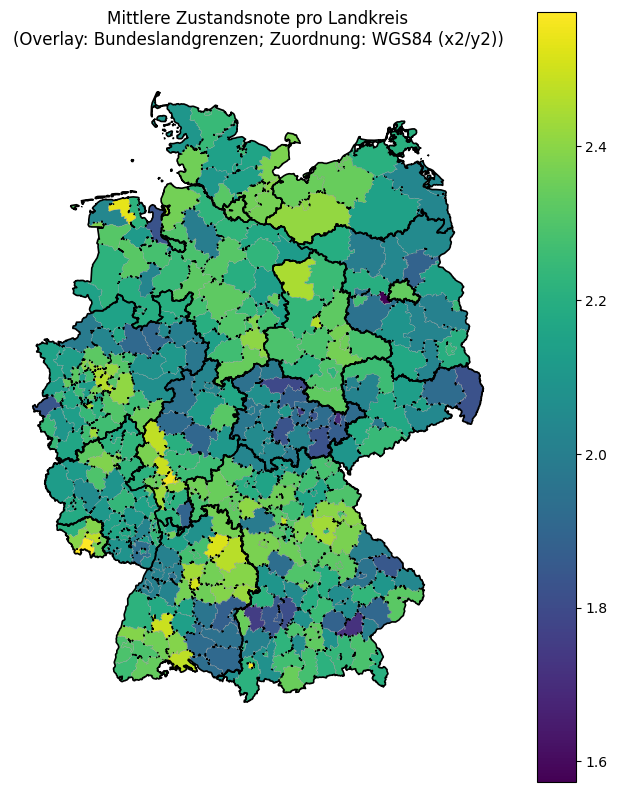

In [9]:
# pip install geopandas pandas shapely pyproj matplotlib

import re
import unicodedata
from pathlib import Path
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# === Dateien ===
csv_path  = Path("data/bridge_statistic_germany.csv")  # deine Brücken-CSV
geo_path  = Path("landkreise_simplify200.geojson")                         # Landkreise-GeoJSON
out_csv   = Path("kreise_zustandsnote_mittel.csv")
out_png   = Path("kreise_zustandsnote_mittel.png")

# === 1) Landkreise laden ===
gdf_kreise = gpd.read_file(geo_path)

def pick_first(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

colsK = gdf_kreise.columns
col_name = pick_first(colsK, ["GEN", "NAME_3", "NAME", "GEN_NAME", "KREIS"])
col_ags  = pick_first(colsK, ["AGS", "AGS_0", "RS", "RS_0", "ID_3"])
col_sn_l = pick_first(colsK, ["SN_L"])  # Bundesland-Schlüssel, falls vorhanden

if gdf_kreise.crs is None:
    gdf_kreise = gdf_kreise.set_crs(4326)
else:
    gdf_kreise = gdf_kreise.to_crs(4326)

# === 2) Brücken-CSV laden (deutsches Format) ===
df = pd.read_csv(csv_path, sep=';', decimal=',', dtype=str, keep_default_na=False)

# sicherstellen, dass diese Spalten existieren
for sp in ["Zustandsnote","x2","y2","X","Y","Kreis"]:
    if sp not in df.columns:
        df[sp] = ""

# Zustandsnote numerisch
df["Zustandsnote"] = pd.to_numeric(df["Zustandsnote"].str.replace(",", ".", regex=False), errors="coerce")

# === 3) Punkte erzeugen (bevorzugt x2/y2 in WGS84) ===
def make_points_from_lonlat(dfin, lon_col="x2", lat_col="y2"):
    lon = pd.to_numeric(dfin[lon_col].str.replace(",", ".", regex=False), errors="coerce")
    lat = pd.to_numeric(dfin[lat_col].str.replace(",", ".", regex=False), errors="coerce")
    ok = lon.notna() & lat.notna()
    g = gpd.GeoDataFrame(dfin[ok].copy(),
                         geometry=[Point(xy) for xy in zip(lon[ok], lat[ok])],
                         crs=4326)
    return g

def make_points_from_utm(dfin, x_col="X", y_col="Y", epsg=25832):
    xx = pd.to_numeric(dfin[x_col].str.replace(",", ".", regex=False), errors="coerce")
    yy = pd.to_numeric(dfin[y_col].str.replace(",", ".", regex=False), errors="coerce")
    ok = xx.notna() & yy.notna()
    g = gpd.GeoDataFrame(dfin[ok].copy(),
                         geometry=[Point(xy) for xy in zip(xx[ok], yy[ok])],
                         crs=epsg).to_crs(4326)
    return g

gdf_pts = make_points_from_lonlat(df, "x2", "y2")
used_coords = "WGS84 (x2/y2)"
if len(gdf_pts) == 0:
    gdf_pts = make_points_from_utm(df, "X", "Y", epsg=25832)
    used_coords = "UTM32 (EPSG:25832)"

# === 4) Räumlicher Join (wenn Punkte vorhanden) ===
spatial_join_ok = len(gdf_pts) > 0
if spatial_join_ok:
    joined = gpd.sjoin(gdf_pts, gdf_kreise[[col_name, col_ags, "geometry"]],
                       how="left", predicate="within")
else:
    joined = None

# === 5) Fallback-Namensabgleich OHNE unidecode ===
def norm_name(s: str) -> str:
    s = str(s).strip().lower()
    s = s.replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss")
    s = unicodedata.normalize("NFKD", s).encode("ascii","ignore").decode("ascii")
    s = re.sub(r"\b(landkreis|kreisfreie stadt|kreis|stadt|region|lkr\.?)\b", "", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

kreise_names = gdf_kreise[[col_name]].copy()
kreise_names["__kreis_norm__"] = kreise_names[col_name].map(norm_name)

if spatial_join_ok:
    base = joined
else:
    base = df.copy()

base["__br_kreis_norm__"] = base["Kreis"].map(norm_name)

name_map = dict(zip(kreise_names["__kreis_norm__"], gdf_kreise[col_name]))
map_series = base["__br_kreis_norm__"].map(name_map)

if spatial_join_ok:
    if col_name in base.columns:
        base[col_name] = base[col_name].fillna(map_series)
    else:
        base[col_name] = map_series
else:
    base[col_name] = map_series

# === 6) Aggregation ===
agg = (
    base
    .dropna(subset=["Zustandsnote", col_name])
    .groupby(col_name, as_index=False)
    .agg(
        n_bridges=("Zustandsnote","size"),
        mean_zust=("Zustandsnote","mean"),
        median_zust=("Zustandsnote","median")
    )
)

if col_ags is not None:
    kreise_keys = gdf_kreise[[col_name, col_ags]].drop_duplicates()
    agg = agg.merge(kreise_keys, on=col_name, how="left")
    agg = agg[["AGS", col_name, "n_bridges", "mean_zust", "median_zust"]] \
             .rename(columns={col_name:"NAME"})
else:
    agg = agg[[col_name, "n_bridges", "mean_zust", "median_zust"]] \
             .rename(columns={col_name:"NAME"})

agg = agg.sort_values("NAME").reset_index(drop=True)

# === 7) Speichern ===
#agg.to_csv(out_csv, index=False, encoding="utf-8")
# print(f"[OK] CSV geschrieben: {out_csv.resolve()}")
# print(agg.head(10).to_string(index=False))

# === 8) Karte rendern (mit Bundesland-Grenzen als Overlay) ===
try:
    # 8.1 Choropleth pro Landkreis
    gplot = gdf_kreise.merge(agg, left_on=col_name, right_on="NAME", how="left")

    fig, ax = plt.subplots(figsize=(8,10))
    gplot.plot(
        ax=ax,
        column="mean_zust",
        legend=True,
        edgecolor="0.6",
        linewidth=0.2,
        missing_kwds={"color":"lightgrey","hatch":"///","label":"keine Daten"}
    )

    # 8.2 Bundesland-Schlüssel bestimmen (SN_L oder aus AGS ableiten)
    #     BL-Code = erste zwei Stellen der AGS; falls SN_L existiert, wird dieser genutzt.
    gdf_bl_key = gdf_kreise[[ "geometry" ]].copy()
    if col_sn_l is not None:
        gdf_bl_key["BL"] = gdf_kreise[col_sn_l].astype(str).str.zfill(2)
    elif col_ags is not None:
        gdf_bl_key["BL"] = gdf_kreise[col_ags].astype(str).str[:2]
    else:
        raise ValueError("Kein Schlüssel für Bundesländer gefunden (weder SN_L noch AGS).")

    # 8.3 Zu Bundesländern aggregieren und Grenzen zeichnen
    gdf_bundeslaender = gdf_bl_key.dissolve(by="BL")  # MultiPolygons pro BL
    # # Optional: kleine Topologie-Reparatur
    bad = ~gdf_bundeslaender.is_valid
    if bad.any():
        gdf_bundeslaender.loc[bad, "geometry"] = gdf_bundeslaender.loc[bad, "geometry"].buffer(0)

    # Overlay: kräftigere Linien für Ländergrenzen
    gdf_bundeslaender.boundary.plot(ax=ax, linewidth=1.2, edgecolor="black")

    ax.set_axis_off()
    ax.set_title(
        f"Mittlere Zustandsnote pro Landkreis\n(Overlay: Bundeslandgrenzen; Zuordnung: {used_coords if spatial_join_ok else 'Name-Match'})",
        pad=12
    )
    # plt.savefig(out_png, dpi=200, bbox_inches="tight")
    # plt.show()
    # print(f"[OK] Karte gespeichert: {out_png.resolve()}")

except Exception as e:
    print("[Hinweis] Choropleth nicht erzeugt:", e)


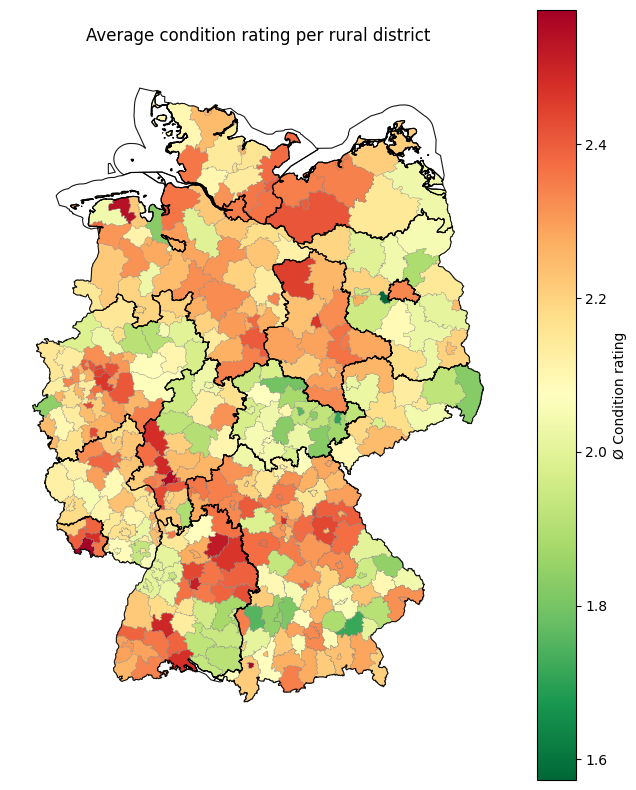

In [11]:
# --- Bundesländer laden (separate Datei) ---
states_path = Path("bundeslaender_simplify0.geojson")
gdf_states = gpd.read_file(states_path)

# CRS angleichen
if gdf_states.crs is None:
    gdf_states = gdf_states.set_crs(4326)
else:
    gdf_states = gdf_states.to_crs(4326)

# Falls die Datei schon Bundesländer enthält: nichts dissolven.
# (Wenn es doch mehrere Geometrien pro Land sind, kannst du optional:
# gdf_states = gdf_states.dissolve(by="RS" oder "GEN" oder "AGS", as_index=False))

# --- Karte zeichnen ---
gplot = gdf_kreise.merge(agg, left_on=col_name, right_on="NAME", how="left")

fig, ax = plt.subplots(figsize=(8,10))



gplot.plot(
    ax=ax,
    column="mean_zust",
    cmap="RdYlGn_r",
    legend=True,
    edgecolor="0.5",
    linewidth=0.2,
    legend_kwds={"label": "Ø Condition rating"},
    missing_kwds={"color":"lightgrey","hatch":"///","label":"keine Daten"}
)
# Bundesländer-Grenzen oben drüber – dünn, leicht transparent
gdf_states.boundary.plot(ax=ax, linewidth=0.8, edgecolor="black", alpha=0.9)

ax.set_axis_off()
ax.set_title(
    ("Average condition rating per rural district"),
    pad=12
)
#plt.savefig(out_png, dpi=200, bbox_inches="tight")
plt.show()


In [12]:
#thüringen and sachsen anhalt ich will die beiden bundesländer vergleichen
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. CSV einlesen ---
csv_path  = Path("data/bridge_statistic_germany.csv")

# Falls deine CSV mit Komma statt Semikolon getrennt ist, sep weglassen oder anpassen
df = pd.read_csv(csv_path, sep=";")

# Schau dir einmal die Spalten an, damit du gleich die richtigen Namen einsetzen kannst
print(df.columns)
df.head()



Index(['ObjectID', 'Bauwerksname', 'Bauwerksnummer', 'Teilbauwerksnummer',
       'ID Nr', 'Baujahr Überbau', 'Baujahr Unterbau', 'Altersklasse',
       'Zustandsnotenklasse', 'Zustandsnote', 'Baustoffklasse',
       'Baustoff Überbau', 'Länge (m)', 'Längenklasse', 'Breite (m)',
       'Fläche (qm)', 'Zugeordneter Sachverhalt',
       'Zugeordneter Sachverhalt vereinfacht', 'Höchste Sachverhalt oben',
       'Höchste Sachverhalt unten', 'Teil der BASt-Liste', 'Konstruktion',
       'Status der Nr', 'Traglastindex', 'Teilbauwerksstadium',
       'Teilbauwerksart', 'Teilbauwerk vord Netz', 'Sperrung SV',
       'Substanzkennzahl', 'Jahr letzte Hauptprüfung', 'Jahresstatistik Lage',
       'Jahresstatistik Lage vereinfacht', 'Meisterei', 'Amt', 'Ort', 'Kreis',
       'Bundesland', 'Bundeslandname', 'Datum der Datenlieferung', 'X', 'Y',
       'x2', 'y2'],
      dtype='object')


,ObjectID,Bauwerksname,Bauwerksnummer,Teilbauwerksnummer,ID Nr,Baujahr Überbau,Baujahr Unterbau,Altersklasse,Zustandsnotenklasse,Zustandsnote,...,Amt,Ort,Kreis,Bundesland,Bundeslandname,Datum der Datenlieferung,X,Y,x2,y2
0,1,B 5 / Süderau/,1019500,0,1019500 0,1973,1973.0,1970 - 1974,2.0 - 2.4,2,...,LBV.SH Flensburg,Süderlügum,Kreis Nordfriesland,1.0,Schleswig - Holstein,01.09.2024,494249,6084092,"8,91031083","54,90381663"
1,2,B 5 / Bosbüller Sielzug/,1119503,0,1119503 0,1961,1961.0,1960 - 1964,2.0 - 2.4,"2,2",...,LBV.SH Flensburg,Süderlügum,Kreis Nordfriesland,1.0,Schleswig - Holstein,01.09.2024,"492729,1875","6074868,5","8,886841107","54,82090884"
2,3,B 5 / Kleiner Strom/,1119505,0,1119505 0,1962,1962.0,1960 - 1964,2.0 - 2.4,"2,2",...,LBV.SH Flensburg,Süderlügum,Kreis Nordfriesland,1.0,Schleswig - Holstein,01.09.2024,"494362,5","6083232,5","8,912097731","54,89609398"
3,4,"B 5 / Geh- und Radweg ""Klixbüll""/",1119512,0,1119512 0,1981,1981.0,1980 - 1984,1.5 - 1.9,"1,9",...,LBV.SH Flensburg,Klixbüll,Kreis Nordfriesland,1.0,Schleswig - Holstein,01.09.2024,"492425,1875","6073092,5","8,882156293","54,804944"
4,5,Geh-/Radweg entl. B 5 / Dreiharder Gotteskoogs...,1119514,0,1119514 0,1986,1986.0,1985 - 1989,1.0 - 1.4,1,...,LBV.SH Flensburg,Süderlügum,Kreis Nordfriesland,1.0,Schleswig - Holstein,01.09.2024,"492819,6875",6075579,"8,888231965","54,82729517"


In [19]:
df["Bundeslandname"].unique()
df["Bundeslandname"].value_counts()

Bundeslandname
Freistaat Bayern               11017
Nordrhein-Westfalen (NRW)       8959
Land Baden-Württemberg          5956
Niedersachsen                   5545
Hessen                          4681
Rheinland - Pfalz               4223
Freistaat Sachsen               2107
Brandenburg                     1833
Thueringen                      1751
Schleswig - Holstein            1632
Sachsen-Anhalt                  1581
Mecklenburg-Vorpommern           987
Saarland                         777
Freie Hansestadt Bremen          277
Berlin                           237
Freie u. Hansestadt Hamburg      233
Name: count, dtype: int64

In [26]:

df["Zustandsnote_num"] = (
    df["Zustandsnote"]
      .astype(str)                    # alles als String behandeln
      .str.replace(",", ".", regex=False)  # Komma durch Punkt ersetzen
      .pipe(pd.to_numeric, errors="coerce")  # in float umwandeln, Fehler -> NaN
)

print(df["Zustandsnote_num"].head())
print(df["Zustandsnote_num"].dtype)



0    2.0
1    2.2
2    2.2
3    1.9
4    1.0
Name: Zustandsnote_num, dtype: float64
float64


In [28]:
mean_by_state = (
    df.groupby("Bundeslandname")["Zustandsnote_num"]
      .mean()
      .reset_index()
      .rename(columns={"Zustandsnote_num": "mean_zustandsnote"})
)

# optional: runden und sortieren
mean_by_state["mean_zustandsnote"] = mean_by_state["mean_zustandsnote"].round(2)
mean_by_state = mean_by_state.sort_values("mean_zustandsnote")

print(mean_by_state)


                 Bundeslandname  mean_zustandsnote
15                   Thueringen               1.94
1                   Brandenburg               2.06
5             Freistaat Sachsen               2.08
11            Rheinland - Pfalz               2.18
10    Nordrhein-Westfalen (NRW)               2.19
4              Freistaat Bayern               2.20
7        Land Baden-Württemberg               2.22
6                        Hessen               2.24
14         Schleswig - Holstein               2.25
9                 Niedersachsen               2.25
8        Mecklenburg-Vorpommern               2.26
13               Sachsen-Anhalt               2.29
2       Freie Hansestadt Bremen               2.30
0                        Berlin               2.33
3   Freie u. Hansestadt Hamburg               2.35
12                     Saarland               2.42


In [36]:

referenzjahr = 2025
df["Alter"] = referenzjahr - pd.to_numeric(df["Baujahr Überbau"], errors="coerce")
vergleich = (
    df
    .groupby("Bundeslandname")
    .agg(
        anzahl_bruecken   = ("Zustandsnote_num", "count"),
        mean_zustandsnote = ("Zustandsnote_num", "mean"),
        mean_alter        = ("Alter", "mean")
    )
    .reset_index()
)

vergleich["mean_zustandsnote"] = vergleich["mean_zustandsnote"].round(2)
vergleich["mean_alter"]        = vergleich["mean_alter"].round(1)

print(vergleich)



                 Bundeslandname  anzahl_bruecken  mean_zustandsnote  \
0                        Berlin              237               2.33   
1                   Brandenburg             1833               2.06   
2       Freie Hansestadt Bremen              277               2.30   
3   Freie u. Hansestadt Hamburg              233               2.35   
4              Freistaat Bayern            11017               2.20   
5             Freistaat Sachsen             2107               2.08   
6                        Hessen             4681               2.24   
7        Land Baden-Württemberg             5956               2.22   
8        Mecklenburg-Vorpommern              987               2.26   
9                 Niedersachsen             5545               2.25   
10    Nordrhein-Westfalen (NRW)             8959               2.19   
11            Rheinland - Pfalz             4223               2.18   
12                     Saarland              777               2.42   
13    

In [44]:
import pandas as pd
from pathlib import Path

csv_path = Path("data/bridge_statistic_germany.csv")
df = pd.read_csv(csv_path, sep=";")

# 1) Nur Thüringen und Sachsen-Anhalt
df_two = df[df["Bundeslandname"].isin(["Thueringen", "Sachsen-Anhalt"])].copy()

# 2) Zustandsnote in float umwandeln (Komma -> Punkt)
df_two["Zustandsnote_num"] = (
    df_two["Zustandsnote"]
      .astype(str)
      .str.replace(",", ".", regex=False)
      .pipe(pd.to_numeric, errors="coerce")
)

# 3a) Falls du eine Spalte "Alter" (in Jahren) hast:
# df_two["Alter_num"] = pd.to_numeric(df_two["Alter"], errors="coerce")

# 3b) Falls du eine Spalte "Baujahr" hast (Alter = Referenzjahr - Baujahr):
referenzjahr = 2024
df_two["Alter_num"] = (
    referenzjahr - pd.to_numeric(df_two["Baujahr Unterbau"], errors="coerce")
)

# kurz checken:
print(df_two[["Bundeslandname", "Baustoffklasse", "Alter_num", "Zustandsnote_num"]].head(20))


      Bundeslandname      Baustoffklasse  Alter_num  Zustandsnote_num
2121  Sachsen-Anhalt  Stahl/Leichtmetall       34.0               2.6
2131  Sachsen-Anhalt          Spannbeton       46.0               3.5
2132  Sachsen-Anhalt          Spannbeton       46.0               2.9
2133  Sachsen-Anhalt        Stahlverbund       46.0               3.5
2240  Sachsen-Anhalt                Holz       29.0               3.2
2241  Sachsen-Anhalt    Beton/Stahlbeton       19.0               2.3
2242  Sachsen-Anhalt    Beton/Stahlbeton       17.0               1.9
2243  Sachsen-Anhalt          Spannbeton       18.0               2.3
2244  Sachsen-Anhalt    Beton/Stahlbeton       17.0               2.2
2245  Sachsen-Anhalt    Beton/Stahlbeton       22.0               2.3
2246  Sachsen-Anhalt          Spannbeton       19.0               2.5
2247  Sachsen-Anhalt    Beton/Stahlbeton       19.0               2.2
2248  Sachsen-Anhalt    Beton/Stahlbeton       19.0               2.2
2249  Sachsen-Anhalt

In [47]:
baustoff_counts = (
    df_two
    .groupby(["Bundeslandname", "Baustoffklasse"])
    .size()
    .unstack(fill_value=0)
)

print(baustoff_counts)
baustoff_percent = baustoff_counts.div(baustoff_counts.sum(axis=1), axis=0) * 100
baustoff_percent = baustoff_percent.round(1)

print(baustoff_percent)


Baustoffklasse  Beton/Stahlbeton  Holz  Spannbeton  Stahl/Leichtmetall  \
Bundeslandname                                                           
Sachsen-Anhalt               770    15         622                  40   
Thueringen                   994     5         514                  49   

Baustoffklasse  Stahlverbund  Stein  
Bundeslandname                       
Sachsen-Anhalt           101     33  
Thueringen               147     42  
Baustoffklasse  Beton/Stahlbeton  Holz  Spannbeton  Stahl/Leichtmetall  \
Bundeslandname                                                           
Sachsen-Anhalt              48.7   0.9        39.3                 2.5   
Thueringen                  56.8   0.3        29.4                 2.8   

Baustoffklasse  Stahlverbund  Stein  
Bundeslandname                       
Sachsen-Anhalt           6.4    2.1  
Thueringen               8.4    2.4  


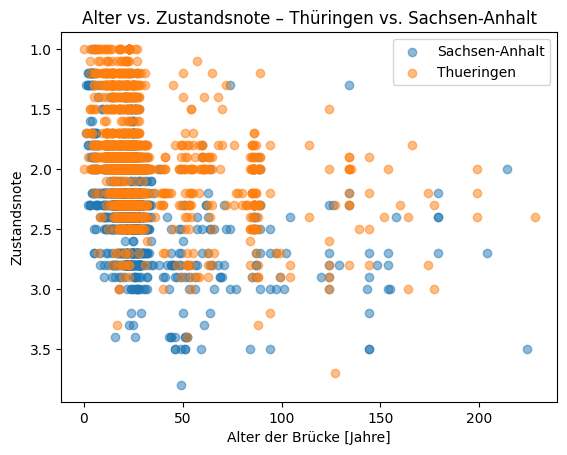

In [48]:
import matplotlib.pyplot as plt

plt.figure()
for name, gruppe in df_two.groupby("Bundeslandname"):
    plt.scatter(
        gruppe["Alter_num"],
        gruppe["Zustandsnote_num"],
        alpha=0.5,
        label=name
    )

plt.xlabel("Alter der Brücke [Jahre]")
plt.ylabel("Zustandsnote")
plt.title("Alter vs. Zustandsnote – Thüringen vs. Sachsen-Anhalt")
plt.legend()
plt.gca().invert_yaxis()  # falls kleinere Note = besser, optional
plt.show()


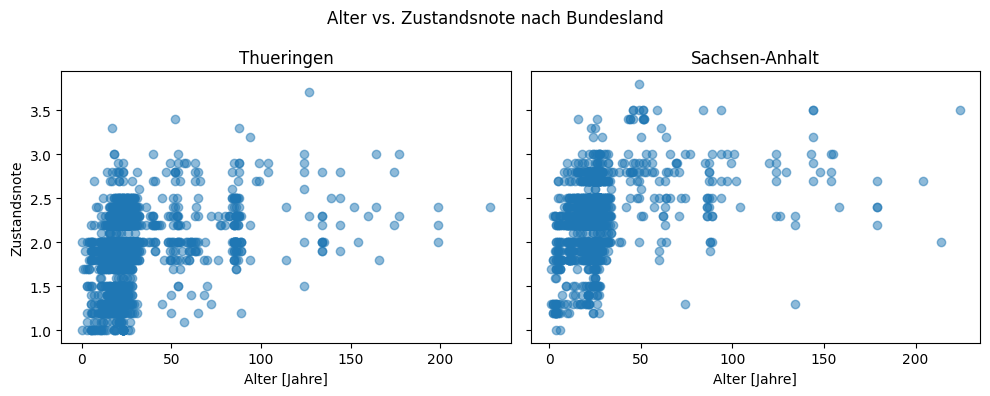

In [50]:
bundeslaender = ["Thueringen", "Sachsen-Anhalt"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, bl in zip(axes, bundeslaender):
    teil = df_two[df_two["Bundeslandname"] == bl]
    ax.scatter(teil["Alter_num"], teil["Zustandsnote_num"], alpha=0.5)
    ax.set_title(bl)
    ax.set_xlabel("Alter [Jahre]")
    ax.invert_yaxis()  # optional

axes[0].set_ylabel("Zustandsnote")

plt.suptitle("Alter vs. Zustandsnote nach Bundesland")
plt.tight_layout()
plt.show()


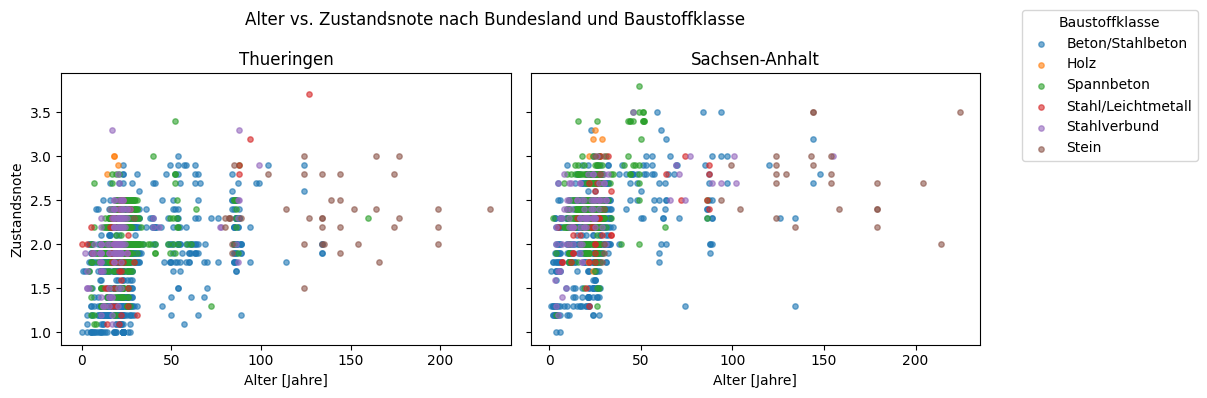

In [61]:
bundeslaender = ["Thueringen", "Sachsen-Anhalt"]
baustoff_col = "Baustoffklasse"  # falls deine Spalte anders heißt: hier anpassen

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, bl in zip(axes, bundeslaender):
    teil = df_two[df_two["Bundeslandname"] == bl]

    # nach Baustoffklasse gruppieren und jede Klasse separat plotten
    for stoff, sub in teil.groupby(baustoff_col):
        ax.scatter(
            sub["Alter_num"],
            sub["Zustandsnote_num"],
            alpha=0.6,
            label=stoff,
            s=15
        )

    ax.set_title(bl)
    ax.set_xlabel("Alter [Jahre]")
    ax.invert_yaxis()  # kleinere Zustandsnote oben (optional)

axes[0].set_ylabel("Zustandsnote")

# Nur eine gemeinsame Legende für alle Subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Baustoffklasse", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.suptitle("Alter vs. Zustandsnote nach Bundesland und Baustoffklasse")
plt.tight_layout()
plt.show()


In [62]:
baustoff_anteil = pd.crosstab(
    df_two["Bundeslandname"],
    df_two["Baustoffklasse"],   # oder "Baustoff"
    normalize="index"
) * 100

baustoff_anteil.round(1)


Baustoffklasse,Beton/Stahlbeton,Holz,Spannbeton,Stahl/Leichtmetall,Stahlverbund,Stein
Bundeslandname,,,,,,
Sachsen-Anhalt,48.7,0.9,39.3,2.5,6.4,2.1
Thueringen,56.8,0.3,29.4,2.8,8.4,2.4


In [63]:
df_two["alter_klasse"] = pd.cut(
    df_two["Alter_num"],
    bins=[0, 20, 40, 60, 200],
    labels=["≤20", "21–40", "41–60", ">60"],
    include_lowest=True
)

vergleich_fair = (
    df_two
    .groupby(["alter_klasse", "Bundeslandname"])["Zustandsnote_num"]
    .mean()
    .unstack()
    .round(2)
)

vergleich_fair


C:\Users\NinaMayer\AppData\Local\Temp\ipykernel_26876\3853693979.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["alter_klasse", "Bundeslandname"])["Zustandsnote_num"]


Bundeslandname,Sachsen-Anhalt,Thueringen
alter_klasse,,
≤20,2.14,1.83
21–40,2.30,1.96
41–60,2.89,2.15
>60,2.63,2.23


In [64]:
import statsmodels.formula.api as smf

model = smf.ols(
    "Zustandsnote_num ~ Alter_num + C(Baustoffklasse) + C(Bundeslandname)",
    data=df_two
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       Zustandsnote_num   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     234.1
Date:                Sun, 16 Nov 2025   Prob (F-statistic):          1.45e-283
Time:                        13:35:38   Log-Likelihood:                -1287.1
No. Observations:                3324   AIC:                             2590.
Df Residuals:                    3316   BIC:                             2639.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [55]:
for bl, gruppe in df_two.groupby("Bundeslandname"):
    print(bl, gruppe[["Alter_num", "Zustandsnote_num"]].corr().iloc[0, 1])


Sachsen-Anhalt 0.33298648718096874
Thueringen 0.31543819546941343


In [57]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

csv_path = Path("data/bridge_statistic_germany.csv")
df = pd.read_csv(csv_path, sep=";")

# Zustandsnote in Zahl umwandeln, falls noch nicht geschehen
df["Zustandsnote_num"] = (
    df["Zustandsnote"]
      .astype(str)
      .str.replace(",", ".", regex=False)
      .pipe(pd.to_numeric, errors="coerce")
)

# Alter aus Baujahr berechnen (falls du "Baujahr" hast)
referenzjahr = 2024
df["Alter_num"] = referenzjahr - pd.to_numeric(df["Baujahr Unterbau"], errors="coerce")

# Nur Thüringen und Sachsen-Anhalt
bundeslaender = ["Thueringen", "Sachsen-Anhalt"]
df_two = df[df["Bundeslandname"].isin(bundeslaender)].copy()


<Figure size 640x480 with 0 Axes>

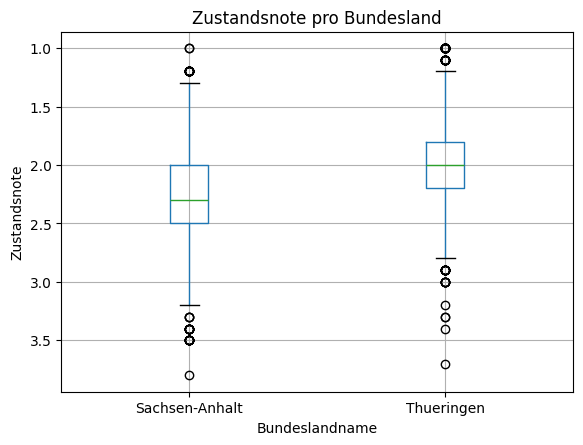

In [59]:
plt.figure()

df_two.boxplot(
    column="Zustandsnote_num",
    by="Bundeslandname"
)

plt.ylabel("Zustandsnote")
plt.title("Zustandsnote pro Bundesland")
plt.suptitle("")  # den automatischen Untertitel entfernen
plt.gca().invert_yaxis()  # optional: bessere Noten (kleinere Zahl) nach oben

plt.show()


<Figure size 640x480 with 0 Axes>

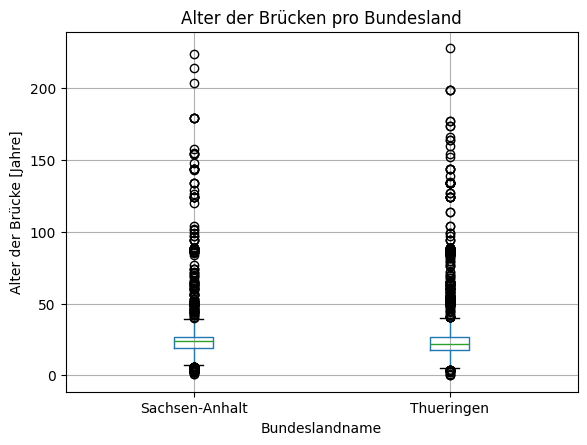

In [60]:
plt.figure()

df_two.boxplot(
    column="Alter_num",
    by="Bundeslandname"
)

plt.ylabel("Alter der Brücke [Jahre]")
plt.title("Alter der Brücken pro Bundesland")
plt.suptitle("")

plt.show()
